## Práctica de Clasificación Lineal: Regresión Logística

Daniel Garcia Diaz (garciad@ifca.unican.es)

En esta práctica utilizaremos el dataset MNIST, compuesto por 60000 imágenes de train y 10000 imagenes de test (de 28x28 pixeles) correspondientes a distintas versiones digitalizadas de los dígitos 0, ..., 9. 

Descargamos el dataset que vamos a utilizar.

In [0]:
#Set the directory to be able to read the data properly
rm(list=ls())
setwd("")

#Install the necessary packages
#install.packages("R.utils")

In [0]:
# download data from http://yann.lecun.com/exdb/mnist/
download.file("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
              "train-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
              "train-labels-idx1-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
              "t10k-images-idx3-ubyte.gz")
download.file("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz",
              "t10k-labels-idx1-ubyte.gz")

# gunzip the files
R.utils::gunzip("train-images-idx3-ubyte.gz")
R.utils::gunzip("train-labels-idx1-ubyte.gz")
R.utils::gunzip("t10k-images-idx3-ubyte.gz")
R.utils::gunzip("t10k-labels-idx1-ubyte.gz")

4 archivos diferentes para crear los datasets de train (x_train->train-image e y_train->train-labels) y de test (x->t10k-images e y->t10k-labels).

Funciones para cargar los archivos


In [0]:
# load image files
load_image_file = function(filename) {
  ret = list()
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n    = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  nrow = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  ncol = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  x = readBin(f, 'integer', n = n * nrow * ncol, size = 1, signed = FALSE)
  close(f)
  data.frame(matrix(x, ncol = nrow * ncol, byrow = TRUE))
}

# load label files
load_label_file = function(filename) {
  f = file(filename, 'rb')
  readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  n = readBin(f, 'integer', n = 1, size = 4, endian = 'big')
  y = readBin(f, 'integer', n = n, size = 1, signed = FALSE)
  close(f)
  y
}

In [0]:
# path images
path_x_train = "https://github.com/davemlz/Master_of_DataScience/raw/master/Estadistica/Pr%C3%A1ctica%20Clasificaci%C3%B3n%20lineal-20191211/data/train-images-idx3-ubyte"
path_x_test = "https://github.com/davemlz/Master_of_DataScience/raw/master/Estadistica/Pr%C3%A1ctica%20Clasificaci%C3%B3n%20lineal-20191211/data/t10k-images-idx3-ubyte"
path_y_train = "https://github.com/davemlz/Master_of_DataScience/raw/master/Estadistica/Pr%C3%A1ctica%20Clasificaci%C3%B3n%20lineal-20191211/data/train-labels-idx1-ubyte"
path_y_test = "https://github.com/davemlz/Master_of_DataScience/raw/master/Estadistica/Pr%C3%A1ctica%20Clasificaci%C3%B3n%20lineal-20191211/data/t10k-labels-idx1-ubyte"

# load images
x_train = load_image_file(path_x_train)
x_test = load_image_file(path_x_test)

# load labels
y_train = load_label_file(path_y_train)
y_test = load_label_file(path_y_test)

Dibujamos los 6 primeros digitos para ver el dataset que tenemos

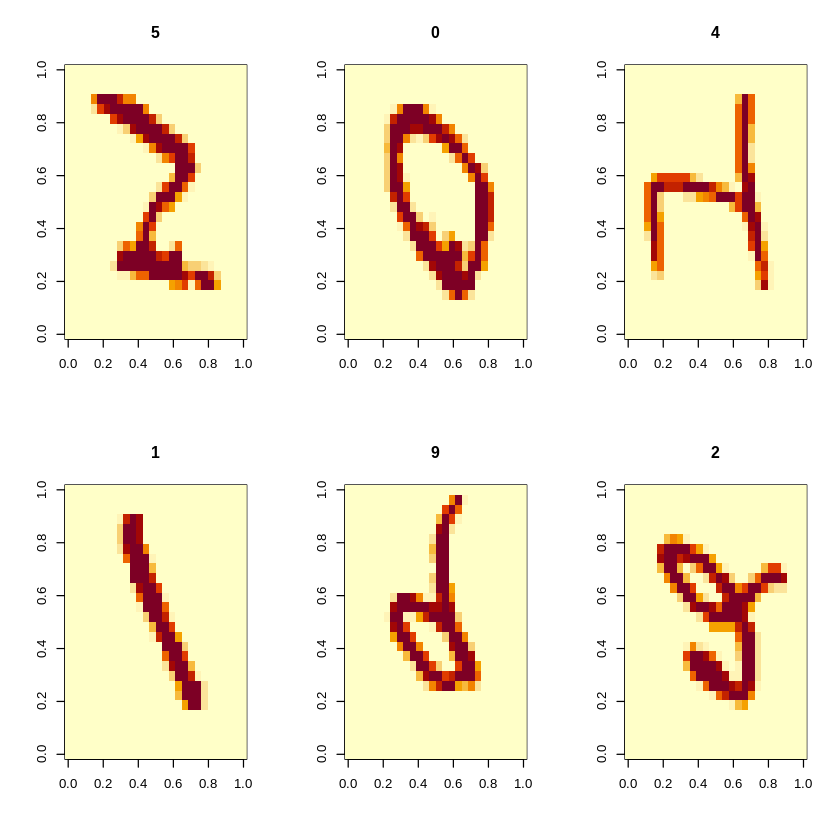

In [3]:
# Dibujamos los 6 primeros dígitos de la base de datos
par(mfrow = c(2,3))
for (i in 1:6) {
    image(matrix(as.matrix(x_train[i,1:784]), nrow = 28, ncol = 28))
    title(y_train[i])
}

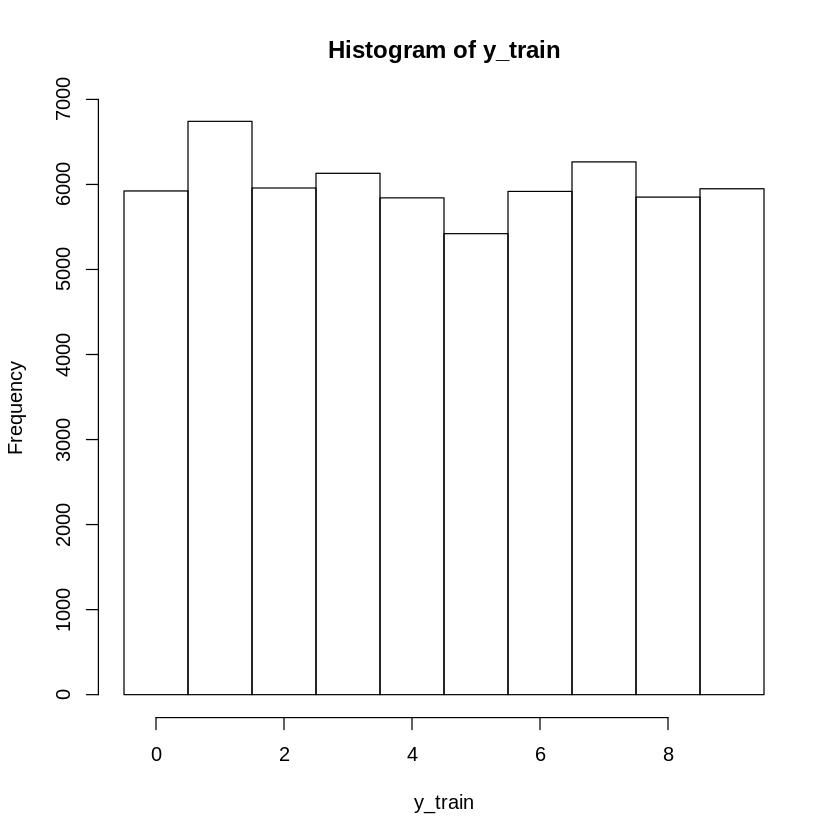

In [4]:
# Cada dígito está igualmente representado en la muestra
hist(y_train, breaks = -0.5:9.5)

El objetivo es clasificar correctamente cada una de las imágenes, utilizando el valor de los 784 pixeles. Este problema se encuandra dentro de la clasificación multi-categoría (tenemos 10 posibles clases a predicir para cada dato). 

Para simplificar estos problemas, se suelen consideran tantos problemas binarios (predecir sí o no) independientes como categorías se tengan. Es decir, un modelo para clasificar 0 (si o no), otro para 1, etc. En este ejemplo, consideramos el dígito '9' y el objetivo es predecir si una imagen es 9 o no.

In [0]:
# Seleccionamos un dígito concreto para tratar de predecirlo. Por ejemplo el nueve
# y9 = 1 si el dígito es 9 y 0 en caso contrario
y9 <- y_train;
y9[which(y_train != 9)] <- 0 ; y9[which(y_train == 9)] <- 1

In [0]:
# Construimos un dataframe para entrenar el modelo
dat <- data.frame(y9,x_train)

Como el tamaño de la muestra es muy grande (60000 imagenes), seleccionamos una muestra para entrenar; por ejemplo, los 5000 primeros dígitos.

In [0]:
i<- 1:5000;
j<-5001:10000
#Random sampling
#i<-sample(1:dim(x)[1],5000);
datT <- dat[i,]
datt <- dat[j,]

Aunque no es el modelo adecuado, ya que no está acotada y puede tomar valores mucho mayores que 1 o menores que 0, construimos primero un modelo de regresión lineal para estos datos.

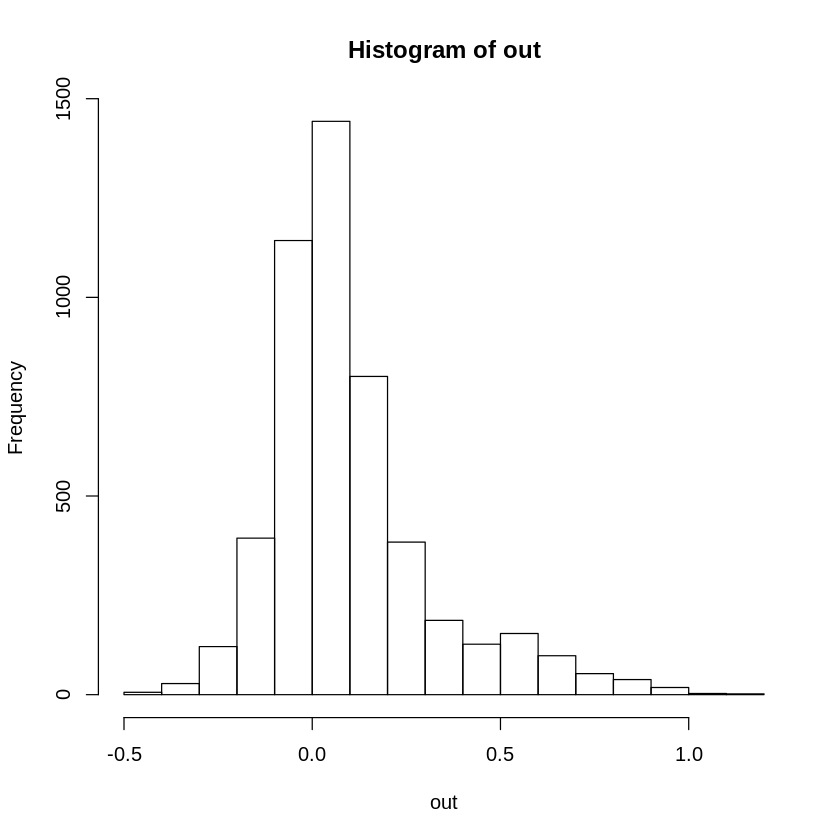

In [8]:
# Entrenamos primero un modelo lineal
model <- lm(datT$y9~., data = datT)
out <- model$fitted.values
# El histograma muestra valores predichos (incluyendo negativos y mayores que 1)
hist(out)

Hacemos la salida del modelo binaria considerando el umbral en 0.5 (a modo de probabilidad) y calculamos la tasa de acierto con los datos de train

In [9]:
# Hacemos binaria la salida considerando el umbral 0.5 (a modo de probabilidad)
outbin <- as.double(out > 0.5)

# Tasa de acierto (en entrenamiento)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)

[1] 96.18

In [10]:
# Tasa de acierto de test
out1<- predict(object=model, newdata = datt);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message in predict.lm(object = model, newdata = datt):
“prediction from a rank-deficient fit may be misleading”

[1] 94.68

Ahora construimos un modelo de regresión logística utilizando la función 'glm' con la familia 'family = binomial(link = "logit")'

In [11]:
model1 <- glm(datT$y9~., data = datT, family = binomial(link = "logit"))

# Problemas de convergencia con tantas variables
# Coefficients: (138 not defined because of singularities)
# Tasa de acierto (Train)
out2 <- model1$fitted.values
outbin2 <- as.double(out2 > 0.5)
100*sum(diag(table(datT[,1], outbin2))) / length(outbin2)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 97.7

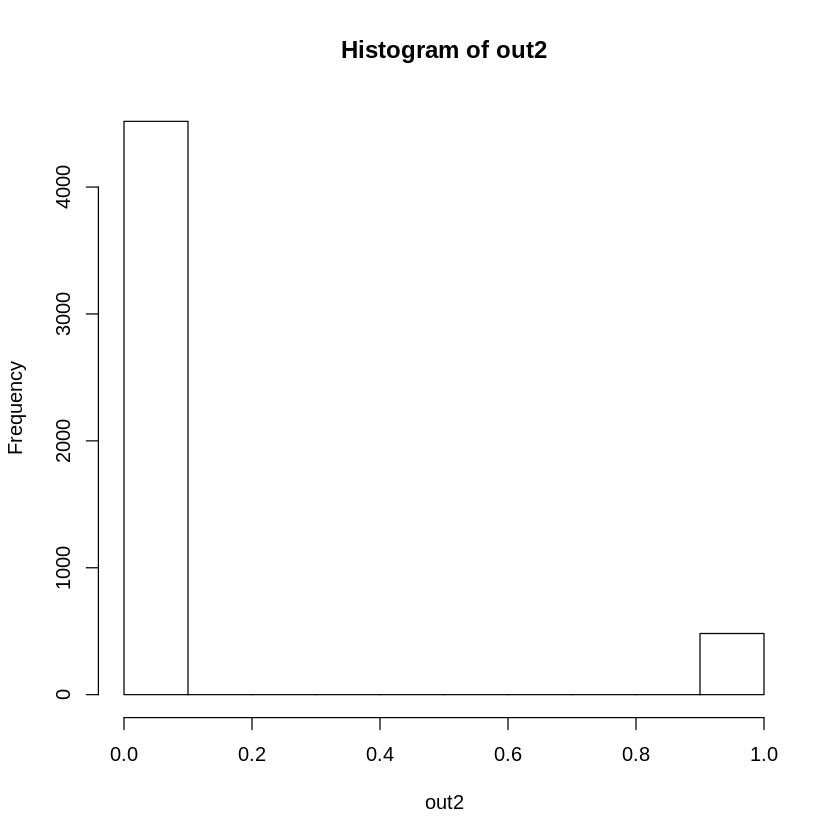

In [12]:
hist(out2)

In [13]:
# Tasa de acierto (test)
out3<- predict(object=model1, newdata = datt);
outbin3 <- as.double(out3 > 0.5)
100*sum(diag(table(datt[,1], outbin3))) / length(outbin3)

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

[1] 92.38

Las inestabilidades numéricas se producen por la alta dimensionalidad de los datos. Algunos de los coeficientes resultan redundantes y el proceso de optimización no converge.
### (195 not defined because of singularities).

Una solución a este problema es reducir la dimensionalidad del conjunto de predictores. Para ello existen técnicas eficientes (como los métodos de regularización o las Componentes Principales) que se verán más adelante. En esta práctica utilizamos un entresacado de información, considerando sólo uno de cada 20 pixeles.

In [14]:
#Modelo de regresión lineal
j<-seq(1,784,20)
model <- lm(datT$y9~., data = datT[,j])
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

[1] 90.28

Warning message in predict.lm(object = model, newdata = datt[, j]):
“prediction from a rank-deficient fit may be misleading”

[1] 91.1

In [15]:
#Regresión logística
j<-seq(1,784,20)
model <- glm(datT$y9~., data = datT[,j], family = binomial(link = "logit"))
out <- model$fitted.values
outbin <- as.double(out > 0.5)
100*sum(diag(table(datT[,1], outbin))) / length(outbin)
out1<- predict(object=model, newdata = datt[,j]);
outbin1 <- as.double(out1 > 0.5)
100*sum(diag(table(datt[,1], outbin1))) / length(outbin1)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

[1] 92.02

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”

[1] 92.26

PRACTICA 1: Construir un modelo de clasificación para cada dígito, y obtener una ranking de los dígitos en base a su capacidad predictiva (el primero el que mejor se predice, etc.). Para evaluar la capacidad predictiva considerando el error de test obtenido al separar aleatoriamente la muestra en un conjunto de train (n=10000) y el resto de test. 

Nota: usar la función 'sample'. 
Nota2: Elige un entresacado óptimo para que la capacidad predictiva no se reduzca y se reduzca la dimensión el máximo posible.

In [0]:
# función para calcular el accuracy
# subset_n se usa para extraer del dataset una cantidad de registros para trabajar con ellos
# train_n se usar para saber cuantos de estos registros serán de entrenamiento, el resto serán test
# digit será el dígito a evaluar
get_glm_score = function(subset_n,train_n,digit){

  # para cada dígito se tendrá el label (0,1)
  y_digit = y_train
  y_digit[which(y_train != digit)] = 0
  y_digit[which(y_train == digit)] = 1

  # se crea el data frame con este label
  dat = data.frame(y_digit,x_train)

  # se extrae una muestra del dataset de tamaño subset_n
  subset_ind = sample(seq_len(nrow(dat)),size = subset_n)
  subset_dat = dat[subset_ind,]

  # de esta muestra se extrae una parte de tamaño train_n para entrenar
  train_ind = sample(seq_len(nrow(subset_dat)),size = train_n)

  # se parte el sub dataset en entrenamiento
  train = dat[train_ind,]

  # y en test
  test = dat[-train_ind,]

  # entresecado de un pixel cada 20
  j = seq(1,784,20)

  # se entrena el glm, en este caso regresión logística
  model = glm(train$y_digit ~ .,data = train[,j], family = binomial(link = "logit"))

  # se predicen los valores de test y se aplica el umbral 0.5
  out = predict(object = model,newdata = test[,j])
  outbin = as.double(out > 0.5)
  
  # se calcula el accuracy
  score = 100 * sum(diag(table(test[,1], outbin))) / length(outbin)
  
  # se retorna el accuracy
  return(score)

}

In [21]:
# digitos
digits = 0:9

# se calculan los accuracies para cada digito en digits
# la muestra del dataset a usar será de tamaño 15000
# de esta muestra 10000 serán de entrenamiento
scores = sapply(digits,get_glm_score,subset_n = 15000,train_n = 10000)

# se guardan los accuracies en un dataframe con los digitos
df = data.frame(digits,scores)

# se ordena el dataframe según el accuracy descendentemente
df = df[order(-scores),]
df

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

,digits,scores
,<int>,<dbl>
1,0,96.320
2,1,96.046
8,7,94.794
3,2,94.408
7,6,93.474
5,4,93.368
6,5,92.260
4,3,92.176
9,8,92.076


Teniendo en cuenta el ranking anterior, el dígito 0 es el que mejor se predice, mientras que el dígito 9 es el que peor se predice.

PRACTICA 2: Tener en cuenta la variabilidad del error de test a la hora de construir el ranking anterior. Para ello, además de calcular la tasa de acierto para cada dígito, considerar también un "intervalo de confianza" obtenido como la dispersión (desviación típica) de 10 medidas de test obtenidas con 10 muestras aleatorias distintas. ¿Existe algún dígito que pueda predecirse significativamente mejor que los demás?

In [22]:
# vector nulo para guardar todos los accuracies
scores_ = NULL

# bucle for para realizar 10 repeticiones del modelo
for(i in 1:10){

  # se calculan los accuracies y se concatenan
  scores = sapply(digits,get_glm_score,subset_n = 15000,train_n = 10000)
  scores_ = c(scores_,scores)

}

# vector de digitos concatenados 10 veces (10 repeticiones)
dig = rep(digits,10)

# data frame de 2x100 con el vector de digitos y el vector de accuracies
dfScores = data.frame(digits = as.factor(dig),scores = scores_)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

In [23]:
require(ggplot2)

Loading required package: ggplot2


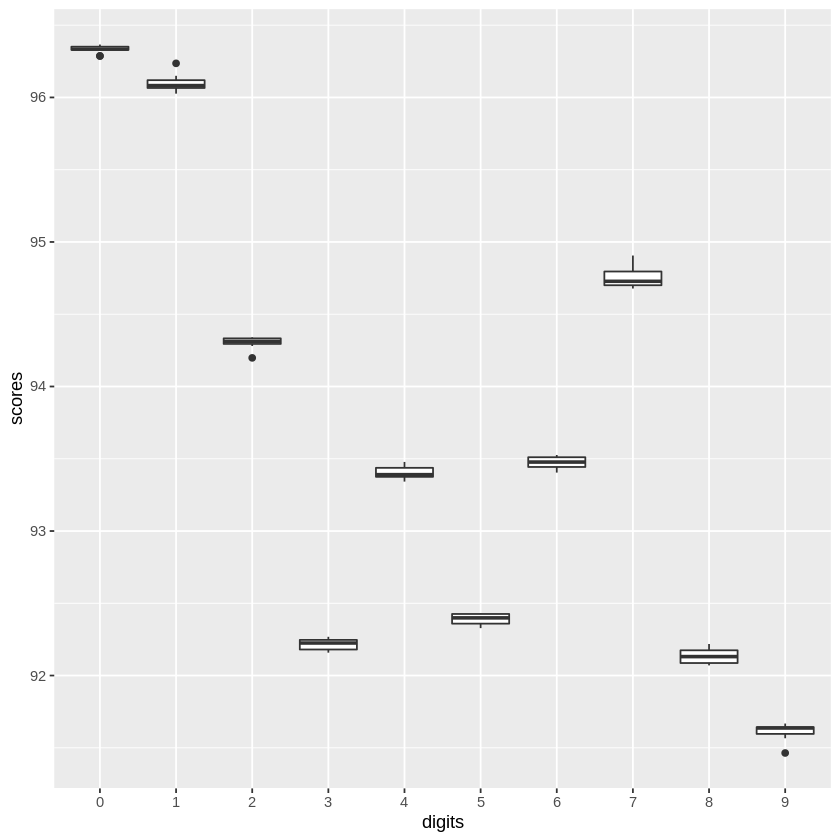

In [25]:
# boxplot de los accuracies para cada dígito
ggplot(dfScores, aes(x = digits, y = scores)) + geom_boxplot()

In [50]:
require(dplyr)

Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [52]:
# obtener media y desviación estándar por cada dígito
dfScores %>% group_by(digits) %>% summarise(mean = mean(scores),sd = sd(scores))

digits,mean,sd
<fct>,<dbl>,<dbl>
0,96.3330,0.02744287
1,96.0974,0.06222575
2,94.3028,0.04230261
3,92.2164,0.03913282
4,93.4042,0.04349662
5,92.3906,0.03880493
6,93.4752,0.04274160
7,94.7572,0.07878635
8,92.1336,0.05238999


El dígito 0 se predice significativamente mejor que los demás, no obstante, el dígito 1 también tiende a tener una muy buena predicción. Se confirma además que el dígito 9 es el que peor se predice con respecto a los demás.

TRABAJO EXTRA: Hasta ahora hemos utilizado la tasa de acierto como medida de validación de los clasificadores. Para ello, las predicciones probabilísticas se tiene que convertir a binarias (utilizando un umbral para al probabilidad). Sin embargo, existen otras medidas más generales que consideran el carácter probabilístico de la predicción. 
Leer https://es.wikipedia.org/wiki/Curva_ROC
Practicar con el paquete 'AUC'
#install.packages("AUC")
#library("AUC")
#roc<-roc(out,as.factor(datT[,1]))
#auc(roc)
#plot(roc)

In [27]:
install.packages('AUC')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


In [0]:
require(AUC)

In [0]:
# función para calcular el ROC
# subset_n se usa para extraer del dataset una cantidad de registros para trabajar con ellos
# train_n se usar para saber cuantos de estos registros serán de entrenamiento, el resto serán test
# digit será el dígito a evaluar
get_roc = function(subset_n,train_n,digit){

  # para cada dígito se tendrá el label (0,1)
  y_digit = y_train
  y_digit[which(y_train != digit)] = 0
  y_digit[which(y_train == digit)] = 1

  # se crea el data frame con este label
  dat = data.frame(y_digit,x_train)

  # se extrae una muestra del dataset de tamaño subset_n
  subset_ind = sample(seq_len(nrow(dat)),size = subset_n)
  subset_dat = dat[subset_ind,]

  # de esta muestra se extrae una parte de tamaño train_n para entrenar
  train_ind = sample(seq_len(nrow(subset_dat)),size = train_n)

  # se parte el sub dataset en entrenamiento
  train = dat[train_ind,]

  # y en test
  test = dat[-train_ind,]

  # entresecado de un pixel cada 20
  j = seq(1,784,20)

  # se entrena el glm, en este caso regresión logística
  model = glm(train$y_digit ~ .,data = train[,j], family = binomial(link = "logit"))

  # se predicen los valores de test y se aplica el umbral 0.5
  out = predict(object = model,newdata = test[,j])
  
  # calcular ROC
  roc = roc(out,as.factor(test[,1]))
    
  # se retorna el ROC
  return(roc)

}

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: algorithm did not converge”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from a rank-deficient fit may be misleading”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occ

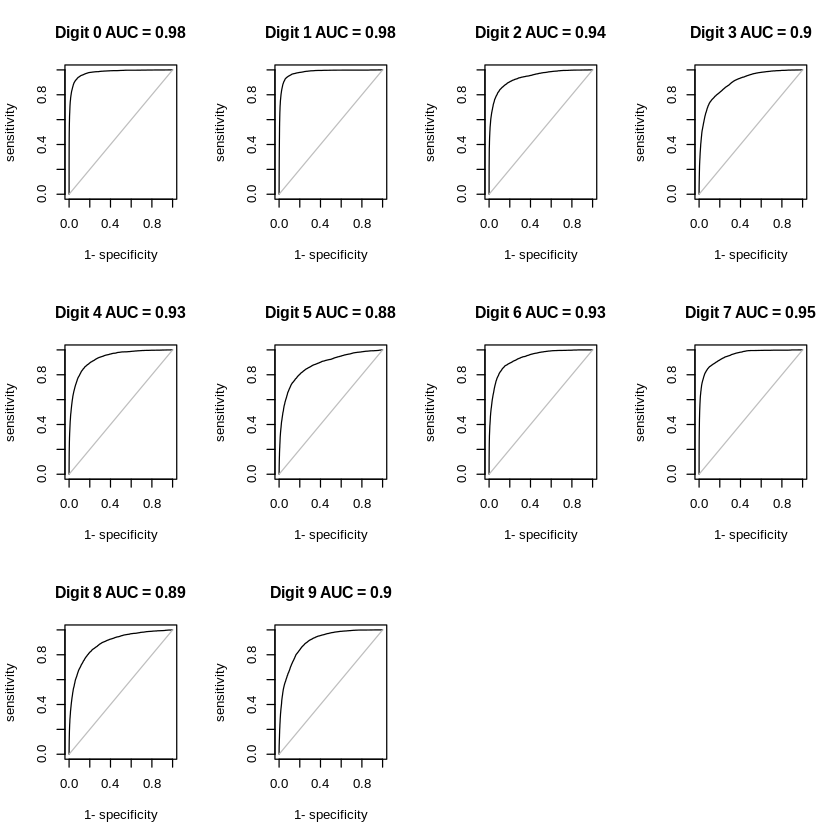

In [48]:
# digitos
digits = 0:9

# se calculan los ROC para cada digito en digits
# la muestra del dataset a usar será de tamaño 15000
# de esta muestra 10000 serán de entrenamiento
rocs = lapply(digits,get_roc,subset_n = 15000,train_n = 10000)

# se calculan los AUC para cada ROC
aucs = sapply(rocs,auc)

# se inicializa una ventana de gráficos de 3x4
par(mfrow = c(3,4))

# se hará un plot de cada ROC
for(i in 1:10){

  # título para mostrar el dígito con su AUC
  the_title = paste("Digit",digits[i],"AUC =",round(aucs[i],2))

  # plot del ROC para cada dígito
  plot(rocs[[i]],main = the_title)

}

Según las gráficas de las curvas ROC para cada dígitos se puede observar cómo los dígitos 0 y 1 tienden a tener un AUC alto y la curva ROC tiende hacia el punto [0,1] (indicando la poca frecuencua de falsos negativos y falsos positivos) de manera más aproximada que el resto de dígitos.